In [7]:
import subprocess
import os
import urllib.request
import time

def setup_neo4j_with_gds():
    container_name = "neo4j"
    password = "password"

    # Crée les dossiers locaux
    os.makedirs("./neo4j_data/plugins", exist_ok=True)
    os.makedirs("./neo4j_data/data", exist_ok=True)
    os.makedirs("./neo4j_data/logs", exist_ok=True)

    # Téléchargement du plugin GDS 2.6
    gds_jar = "./neo4j_data/plugins/neo4j-graph-data-science-2.6.0.jar"
    if not os.path.exists(gds_jar):
        print("Téléchargement de GDS 2.6...")
        url = "https://github.com/neo4j/graph-data-science/releases/download/2.6.0/neo4j-graph-data-science-2.6.0.jar"
        urllib.request.urlretrieve(url, gds_jar)
        print(f"GDS téléchargé ({os.path.getsize(gds_jar)/(1024*1024):.1f} MB)")

    # Stop et supprime l'ancien container si existant
    subprocess.run(['docker', 'stop', container_name], stderr=subprocess.DEVNULL)
    subprocess.run(['docker', 'rm', container_name], stderr=subprocess.DEVNULL)

    # Chemins absolus pour Docker
    paths = {p: os.path.abspath(f"./neo4j_data/{p}") for p in ["plugins","data","logs"]}

    # Lancement de Neo4j Community avec Docker
    cmd = [
        "docker", "run", "--name", container_name,
        "-p", "7474:7474", "-p", "7687:7687",
        "-e", f"NEO4J_AUTH=neo4j/{password}",
        "-e", "NEO4J_dbms_security_procedures_unrestricted=gds.*",
        "-e", "NEO4J_dbms_security_procedures_allowlist=gds.*",
        "-v", f"{paths['plugins']}:/plugins",
        "-v", f"{paths['data']}:/data",
        "-v", f"{paths['logs']}:/logs",
        "-d", "neo4j:5.15.0-community"
    ]
    subprocess.run(cmd, check=True)

    print("Neo4j Community lancé avec GDS 2.6 ! Attente de démarrage complet...")
    time.sleep(20)  # attends 20 secondes pour que Neo4j soit prêt
    print("Neo4j devrait être prêt à se connecter sur bolt://localhost:7687")

# Exécute le setup
setup_neo4j_with_gds()

Téléchargement de GDS 2.6...
GDS téléchargé (54.5 MB)
Neo4j Community lancé avec GDS 2.6 ! Attente de démarrage complet...
Neo4j devrait être prêt à se connecter sur bolt://localhost:7687


In [1]:
!docker ps

CONTAINER ID   IMAGE                    COMMAND                  CREATED       STATUS          PORTS                                                                                      NAMES
fd6e658e9ba4   neo4j:5.15.0-community   "tini -g -- /startup…"   13 days ago   Up 39 minutes   0.0.0.0:7474->7474/tcp, [::]:7474->7474/tcp, 0.0.0.0:7687->7687/tcp, [::]:7687->7687/tcp   neo4j


In [2]:
!docker logs neo4j

Changed password for user 'neo4j'. IMPORTANT: this change will only take effect if performed before the database is started for the first time.
2025-11-13 18:06:06.228+0000 INFO  Logging config in use: File '/var/lib/neo4j/conf/user-logs.xml'
2025-11-13 18:06:06.255+0000 INFO  Starting...
2025-11-13 18:06:07.281+0000 INFO  This instance is ServerId{392e377a} (392e377a-9cc0-4a01-af8a-3b7b8a080387)
2025-11-13 18:06:07.959+0000 INFO  ======== Neo4j 5.15.0 ========
2025-11-13 18:06:08.101+0000 INFO  Progress tracking: enabled
2025-11-13 18:06:08.103+0000 INFO  Memory usage guard: minimum estimate
2025-11-13 18:06:08.122+0000 INFO  GDS license file: null
2025-11-13 18:06:08.125+0000 INFO  GDS license state: unlicensed
2025-11-13 18:06:08.146+0000 INFO  Register GraphDataScience...
2025-11-13 18:06:08.241+0000 INFO  GraphDataScience registered.
2025-11-13 18:06:08.243+0000 INFO  Register GraphDataScienceExtras...
2025-11-13 18:06:08.245+0000 INFO  GraphDataScienceExtras registered.
2025-11-1

In [3]:
!docker images

REPOSITORY   TAG                IMAGE ID       CREATED         SIZE
neo4j        5.15.0-community   d9e2fb1ba398   22 months ago   799MB


In [10]:
from neo4j import GraphDatabase

URI = "bolt://localhost:7687"
AUTH = ("neo4j", "password")

# Connect to Neo4j
try:
    driver = GraphDatabase.driver(URI, auth=AUTH)
    driver.verify_connectivity()  # raises if cannot connect
except Exception as e:
    print("Neo4j connection failed:", e)
    raise

# print the driver object 
driver

In [11]:
import subprocess

cmd = 'docker exec neo4j cypher-shell -u neo4j -p password "RETURN gds.version();"'
result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
print(result.stdout or result.stderr)

Unable to get a routing table for database 'neo4j' because this database is unavailable



In [7]:
def run_query(query):
    with driver.session() as session:
        result = session.run(query)
        return result.to_df()

In [8]:
run_query("""
SHOW DATABASES
""")

,name,type,aliases,access,address,role,writer,requestedStatus,currentStatus,statusMessage,default,home,constituents
0,neo4j,standard,[],read-write,localhost:7687,primary,True,online,offline,An error occurred! Unable to start `DatabaseId...,True,True,[]
1,system,system,[],read-write,localhost:7687,primary,True,online,online,,False,False,[]


In [9]:
run_query("""
CREATE CONSTRAINT StreamUniqueId IF NOT EXISTS
FOR (s:Stream)
REQUIRE s.id IS UNIQUE
""")

DatabaseUnavailable: {code: Neo.TransientError.General.DatabaseUnavailable} {message: The database is not currently available to serve your request, refer to the database logs for more details. Retrying your request at a later time may succeed.}

In [81]:
run_query("""
LOAD CSV WITH HEADERS FROM 'https://bit.ly/3JjgKgZ' AS row
WITH row
WHERE row.id IS NOT NULL AND row.id <> ''
MERGE (s:Stream {id: row.id})
ON CREATE SET
    s.language = row.language;
""")

""


In [82]:
run_query("""
LOAD CSV WITH HEADERS FROM 'https://bit.ly/3S9Uyd8' AS row
WITH row
WHERE row.source IS NOT NULL AND row.source <> ''
  AND row.target IS NOT NULL AND row.target <> ''
CALL {
    WITH row
    MERGE (s1:Stream {id: row.source})
    MERGE (s2:Stream {id: row.target})
    MERGE (s1)-[:CO_VIEWED {
        weight: CASE WHEN row.weight <> '' THEN toInteger(row.weight) ELSE 0 END
    }]->(s2)
} IN TRANSACTIONS OF 500 ROWS
""")

""


In [ ]:
run_query("""
MATCH ()-[r:CO_VIEWED]->()
SET r.viewer = coalesce(r.weight, 0)
""")

run_query("""
MATCH ()-[r:CO_VIEWED]->()
REMOVE r.weight
""")

In [77]:
run_query("""
CALL gds.graph.project(
    'coViewedGraph',
    'Stream',
    {
        CO_VIEWED: {
            orientation: 'UNDIRECTED',
            properties: ['viewer']
        }
    }
)
""")

,nodeProjection,relationshipProjection,graphName,nodeCount,relationshipCount,projectMillis
0,"{'Stream': {'label': 'Stream', 'properties': {}}}","{'CO_VIEWED': {'aggregation': 'DEFAULT', 'orie...",coViewedGraph,3721,525708,445


In [20]:
run_query("""
CALL gds.node2vec.write(
  'coViewedGraph',
  {
    embeddingDimension: 8,
    relationshipWeightProperty: 'viewer',
    inOutFactor: 0.5,
    returnFactor: 1.0,
    walkLength: 40,
    walksPerNode: 10,
    concurrency: 4,
    writeProperty: 'node2vec'
  }
)
""")

,nodeCount,nodePropertiesWritten,preProcessingMillis,computeMillis,writeMillis,configuration,lossPerIteration
0,3721,3721,0,2833,127,"{'writeProperty': 'node2vec', 'walkLength': 40...",[10626536.153600996]


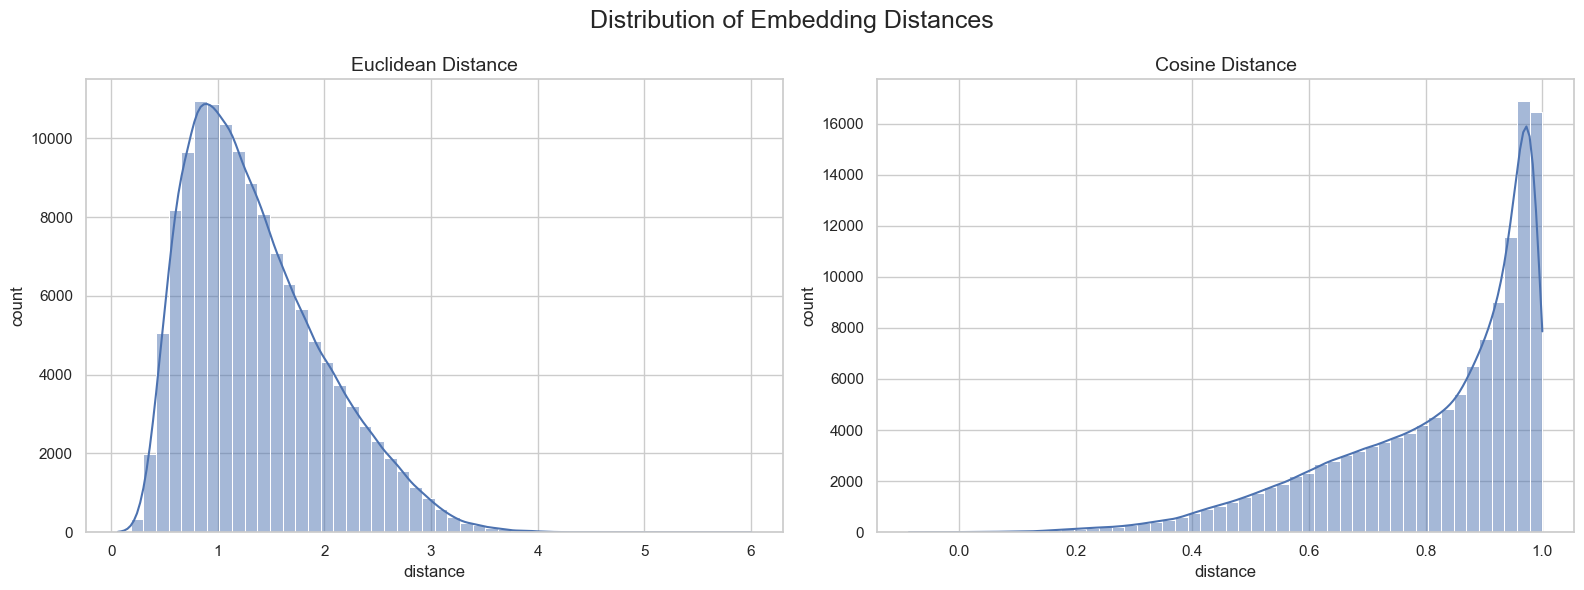

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (16, 6)
sns.set(style="whitegrid")

df = run_query("""
            MATCH (c1:Stream)-[:CO_VIEWED]->(c2:Stream)
            WITH c1.node2vec AS v1, c2.node2vec AS v2
            UNWIND [
            {metric: 'euclidean', value: gds.similarity.euclideanDistance(v1, v2)},
            {metric: 'cosine',    value: gds.similarity.cosine(v1, v2)}
            ] AS m
            RETURN m.value AS distance, m.metric AS metric;
               """)

# --- Subplots ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

metrics = ["euclidean", "cosine"]

for ax, metric in zip(axes, metrics):
    sns.histplot(
        data=df[df["metric"] == metric],
        x="distance",
        bins=50,
        kde=True,
        ax=ax)
    ax.set_title(f"{metric.capitalize()} Distance", fontsize=14)
    ax.set_xlabel("distance")
    ax.set_ylabel("count")

plt.suptitle("Distribution of Embedding Distances", fontsize=18)
plt.tight_layout()
plt.show()

<Axes: xlabel='cosineSimilarity', ylabel='avgDegree'>

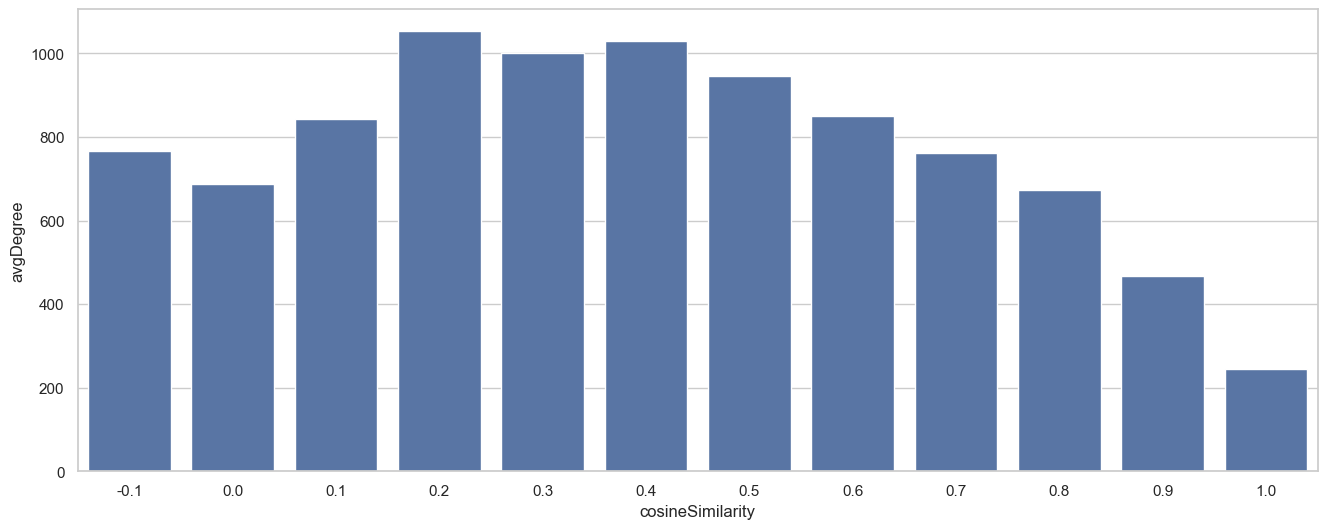

In [37]:
df = run_query("""
MATCH (c1:Stream)-[:CO_VIEWED]->(c2:Stream)
WITH
  round(gds.similarity.cosine(c1.node2vec, c2.node2vec), 1) AS cosineSimilarity,
  count { (c1)--() } + count { (c2)--() } AS degreeSum
RETURN
  cosineSimilarity,
  avg(degreeSum) AS avgDegree
ORDER BY cosineSimilarity;
""")

sns.barplot(data=df,
            x="cosineSimilarity",
            y="avgDegree")

<Axes: xlabel='cosineSimilarity', ylabel='avgWeight'>

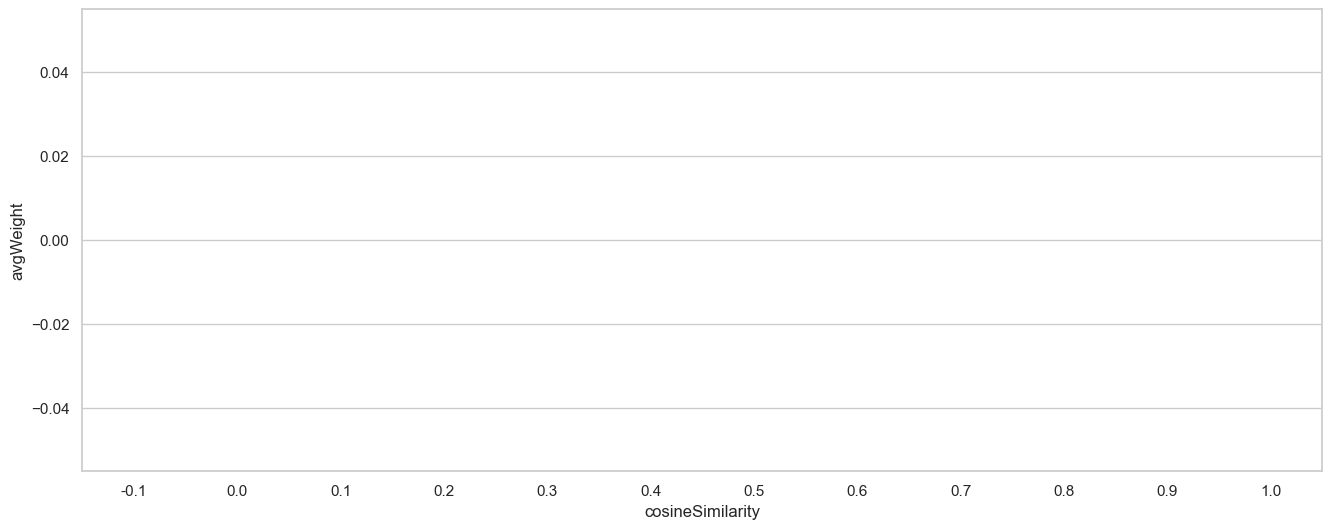

In [ ]:
df = run_query("""
MATCH (c1:Stream)-[r:CO_VIEWED]->(c2:Stream)
WITH
  round(gds.similarity.cosine(c1.node2vec, c2.node2vec), 1) AS cosineSimilarity,
  r.weight AS weight
RETURN
  cosineSimilarity,
  avg(weight) AS avgWeight
ORDER BY cosineSimilarity ASC;
""")

sns.barplot(data=df, 
            x="cosineSimilarity", 
            y="avgWeight")

In [41]:
import pandas as pd
import numpy as np

df = run_query("""
MATCH (s:Stream)
RETURN s.id AS streamId,
       s.language AS language,
       s.node2vec AS embedding
""")

df.columns = ["streamId", "language", "embedding"]
df["embedding"] = df["embedding"].apply(lambda v: np.array(v, dtype=float))
df["language"] = df["language"].fillna("unknown")
codes, uniques = pd.factorize(df["language"], sort=True)
df["label"] = codes

language_mapping = dict(enumerate(uniques))
df.head()

,streamId,language,embedding,label
0,129004176,en,"[0.7951838970184326, 0.0571395568549633, 0.433...",1
1,26490481,en,"[0.3816066384315491, -0.20013444125652313, 0.0...",1
2,213749122,en,"[0.39211395382881165, -1.5505545139312744, -0....",1
3,30104304,en,"[0.2690979838371277, 0.2587355077266693, 0.016...",1
4,160504245,en,"[0.1616283357143402, -0.017714137211441994, 0....",1


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# --- Prepare X and y properly (convert list of vectors into matrix) ---
X = np.vstack(df["embedding"].values)   # shape: (n_samples, embedding_dim)
y = df["label"].values                  # shape: (n_samples,)

# --- Train/test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Random Forest with better defaults ---
model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,
    random_state=42,
)

# --- Train ---
model.fit(X_train, y_train)

,n_estimators,300
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [57]:
# --- Eval ---
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84        56
           1       0.91      0.88      0.90       364
           2       0.85      1.00      0.92        61
           3       0.96      1.00      0.98        50
           4       0.92      0.88      0.90        26
           5       0.96      0.94      0.95        52
           6       0.88      0.92      0.90        38
           7       0.81      0.84      0.83        51
           8       0.89      0.92      0.91        26
           9       0.86      0.86      0.86        21

    accuracy                           0.90       745
   macro avg       0.89      0.91      0.90       745
weighted avg       0.90      0.90      0.90       745



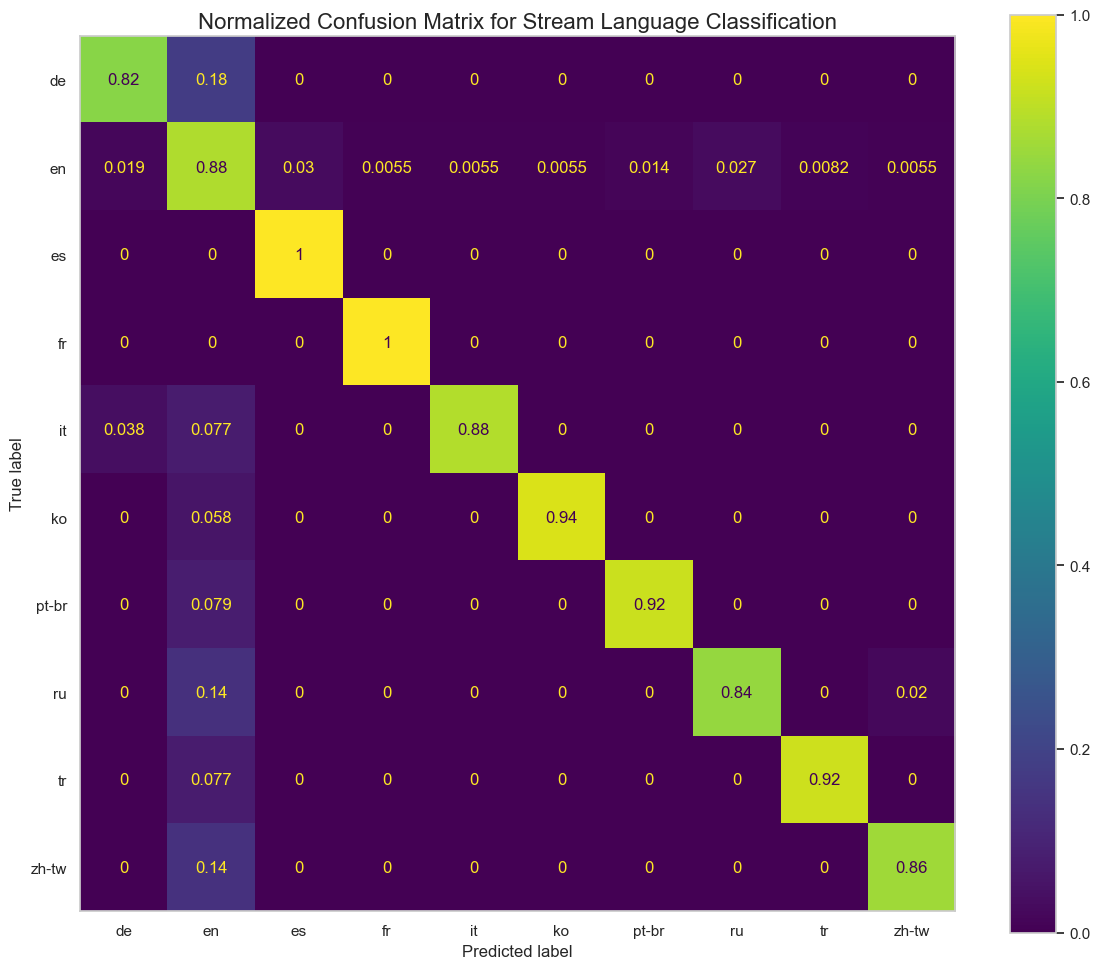

In [67]:
# --- Get class names from language mapping ---
class_names = [language_mapping[i] for i in sorted(language_mapping.keys())]

# --- Plot confusion matrix ---
fig, ax = plt.subplots(figsize=(12, 10))

disp = ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=class_names,
    normalize="true",   # shows proportion instead of raw counts
    ax=ax
)

# --- Remove grid ---
ax.grid(False)

ax.set_title("Normalized Confusion Matrix for Stream Language Classification", fontsize=16)
plt.tight_layout()
plt.show()